Implementing a GPU based Convolutional Neural Network to recognize MNIST digits. I'm still in the process of leaving a bunch of comments

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision.utils import make_grid
import torchvision.transforms as transforms
import torch.nn.functional as F

import numpy as np
from mnist import MNIST

import scipy.misc

import matplotlib.pyplot as plt

In [2]:
mndata = MNIST(path='./data/mnist')
images, labels = mndata.load_training()

In [3]:
# convert to numpy and normalize
images = np.array(images) / 255
labels = np.array(labels)

Plot one of the images just to make sure everything's in a good spot so far.

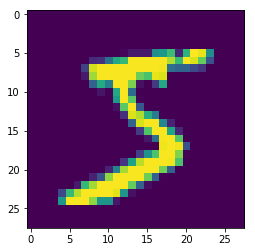

In [4]:
plt.imshow(images[0].reshape(28,28))
plt.show()

I'm also just going to peek at the label to make sure everything seems legit.

In [6]:
labels[0]

5

All good so far. Now, we can proceed with defining the Network

When doing this part, one needs to be extremely careful about the dimensions. I had to actually step through the forward pass in PDB to make everything work correctly.

The main problem is making sure you know the dimensions of your matrices after the max pool operations, so that when you flatten the features, there's no weirdness. Also, be careful how you pass values to the x.view function; if you get it wrong, it might work with one example (well, not work, but wouldn't throw an error), but might die when doing batches.

In [7]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, 3)
        self.pool = nn.MaxPool2d(2,2)
        self.conv2 = nn.Conv2d(16,32, 3)
        self.fc1 = nn.Linear(32 * 5 * 5, 32)
        self.fc2 = nn.Linear(32, 10)
        
    def forward(self, x):
        #import pdb; pdb.set_trace()
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.softmax(self.fc2(x))
        return x
    


Just converting image arrays to numpy ndarray's so we can actually work with them and convert them to torch Tensors

In [8]:

images_tensor = torch.from_numpy(images.reshape(len(images), 1, 28,28))
labels_tensor = torch.from_numpy(labels)

dataset = torch.utils.data.TensorDataset(images_tensor, labels_tensor)

Set up loss, optimizer and data loader.

Loop over epochs and iterate over the dataloader.

In loop, get next batch, propagate examples through network. Subsequently zero out gradients, calculate loss, back prop errors. Make optimizer take a step.

In [12]:
net = Net().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
trainloader = torch.utils.data.DataLoader(dataset, batch_size=256)

num_epochs = 10
loss_progress = []
for i in range(num_epochs):
    for j, data in enumerate(trainloader):
        inputs, output = data
        inputs, output = Variable(inputs.float().cuda()), Variable(output.long().cuda())
        optimizer.zero_grad()
        out = net(inputs)
        loss = criterion(out, output)
        loss.backward()
        optimizer.step()
        if j % 32 == 0:
            loss_progress.append(loss.data[0])
    

Plot the loss to make sure it decreased as time rolled by

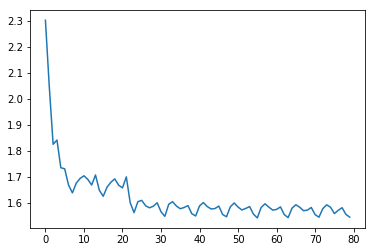

In [13]:
plt.plot(loss_progress)
plt.show()

Now, we're going to try some predictions. We'll have to load up the test set, do some previewing and then run it through our network

In [14]:
images, labels = mndata.load_testing()
images = np.array(images) / 255
labels = np.array(labels)


In [15]:
def plot_images(images):
    fig = plt.figure()
    for i, image in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(image)
    
    plt.show()
        

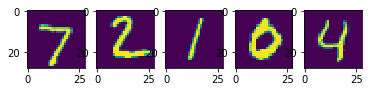

In [16]:
plot_images(images[0:5].reshape(5,28,28))

Now let's run these images through the network and see what we get

In [17]:
test_images_tensor = torch.from_numpy(images[0:5].reshape(5,1,28,28))
out = net(Variable(test_images_tensor.float().cuda()))

_, index = out.max(1)
print(index)

Variable containing:
 7
 2
 1
 0
 4
[torch.cuda.LongTensor of size 5 (GPU 0)]



Run the entire test set through the network and see what you're accuracy is.

In [18]:
test_images_tensor = torch.from_numpy(images.reshape(images.shape[0], 1, 28, 28))
test_images_dataset = torch.utils.data.TensorDataset(test_images_tensor.float(), torch.from_numpy(labels).long()) 

This time, I'm going to evaluate the model on the entire test set and see how we do.

In [57]:
dataloader = torch.utils.data.DataLoader(test_images_dataset, batch_size=256)
preds = []
for i, data in enumerate(dataloader):
    inps, _ = data
    inps = Variable(inps.float().cuda())
    output = net(inps)
    output = output.cpu()
    _, indices = output.max(1)
    for i in indices:
        preds.append(i.data.numpy())
    

In [58]:
len(preds)

10000

In [59]:
preds = np.array(preds)

preds = preds.squeeze()

In [60]:
x = np.equal(preds, labels)
print(np.sum(x))

8875


In [56]:
print("Accuracy =", np.sum(x) / x.shape[0] * 100.0, "%")

Accuracy = 88.75 %


On the whole, not that great; networks can usually get much higher tha